# Transfer Learning with EfficientNet and ResNet18

This notebook implements three transfer learning scenarios:
- **Task 1.1**: No fine-tuning (evaluation only)
- **Task 1.2**: Frozen backbone + fine-tuned classifier
- **Task 1.3**: Full fine-tuning (backbone + classifier)

## Import Libraries and Setup

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration - prioritize MPS for Mac, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    print(f"Using device: CUDA")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")
    
print(f"PyTorch version: {torch.__version__}")

Using device: MPS (Apple Silicon GPU)
PyTorch version: 2.8.0


## Dataset Class with Augmentation

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels, row.iloc[0]  # Also return filename for submission


# Extensive data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Enhanced augmentation for Task 2 (more aggressive to handle class imbalance)
train_transform_enhanced = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),  # Increased rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Stronger color jitter
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),  # Added shear
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),  # More aggressive crop
    transforms.RandomGrayscale(p=0.1),  # Occasional grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Validation/Test transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Data transforms configured with extensive augmentation for training")
print("Enhanced augmentation created for Task 2 (addressing class imbalance)")

Data transforms configured with extensive augmentation for training
Enhanced augmentation created for Task 2 (addressing class imbalance)


## Model Building Function

In [4]:
def build_model(backbone="resnet18", num_classes=3, pretrained_path=None, freeze_backbone=False):
    """
    Build a model with specified backbone and configuration.
    
    Args:
        backbone: "resnet18" or "efficientnet"
        num_classes: Number of output classes
        pretrained_path: Path to pretrained weights
        freeze_backbone: If True, freeze backbone weights (only train classifier)
    
    Returns:
        model: PyTorch model ready for training
    """
    if backbone == "resnet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        # Load pretrained weights if provided
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained ResNet18 from: {pretrained_path}")
        
        # Freeze backbone if requested
        if freeze_backbone:
            for name, param in model.named_parameters():
                if 'fc' not in name:  # Freeze all except final layer
                    param.requires_grad = False
            print(f"🔒 Backbone frozen. Only training classifier layer.")
        else:
            print(f"🔓 All layers trainable (full fine-tuning)")
            
    elif backbone == "efficientnet":
        model = models.efficientnet_b0(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
        # Load pretrained weights if provided
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained EfficientNet from: {pretrained_path}")
        
        # Freeze backbone if requested
        if freeze_backbone:
            for name, param in model.named_parameters():
                if 'classifier' not in name:  # Freeze all except classifier
                    param.requires_grad = False
            print(f"🔒 Backbone frozen. Only training classifier layer.")
        else:
            print(f"🔓 All layers trainable (full fine-tuning)")
    
    else:
        raise ValueError(f"Unsupported backbone: {backbone}. Use 'resnet18' or 'efficientnet'")
    
    return model

print("Model building function ready")

Model building function ready


## Training and Evaluation Functions

In [5]:
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-4, model_save_path="model.pt"):
    """
    Train model with learning rate scheduling and early stopping.
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        epochs: Maximum number of epochs
        lr: Initial learning rate
        model_save_path: Path to save best model
    
    Returns:
        history: Dictionary containing training history
    """
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Learning rate scheduler with patience=3
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Early stopping with patience=5
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': []
    }
    
    print(f"\nStarting training for {epochs} epochs...")
    print(f"Initial LR: {lr}, Scheduler patience: 3, Early stopping patience: {patience}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for imgs, labels, _ in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels, _ in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rates'].append(current_lr)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")
        
        # Learning rate scheduling
        old_lr = current_lr
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"  → Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f"✓ Best model saved (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping triggered after {epoch+1} epochs!")
                break
    
    print(f"\nTraining completed. Best validation loss: {best_val_loss:.4f}")
    return history


def evaluate_model(model, test_loader, dataset_name="Test"):
    """
    Evaluate model and compute metrics with macro F1 scores.
    
    Args:
        model: PyTorch model
        test_loader: Test data loader
        dataset_name: Name of the dataset for display
    
    Returns:
        predictions: numpy array of predictions
        ground_truth: numpy array of ground truth labels
    """
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for imgs, labels, _ in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    disease_names = ["D (DR)", "G (Glaucoma)", "A (AMD)"]
    
    print(f"\n{'='*60}")
    print(f"{dataset_name} Set Evaluation Results")
    print(f"{'='*60}")
    
    f1_scores = []
    
    for i, disease in enumerate(disease_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        
        acc = accuracy_score(y_t, y_p)
        precision = precision_score(y_t, y_p, average="macro", zero_division=0)
        recall = recall_score(y_t, y_p, average="macro", zero_division=0)
        f1 = f1_score(y_t, y_p, average="macro", zero_division=0)
        kappa = cohen_kappa_score(y_t, y_p)
        
        f1_scores.append(f1)
        
        print(f"\n{disease}:")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall   : {recall:.4f}")
        print(f"  F1-score (macro): {f1:.4f}")
        print(f"  Kappa    : {kappa:.4f}")
    
    # Calculate and print average F1 score
    avg_f1 = np.mean(f1_scores)
    print(f"\n{'='*60}")
    print(f"Average F1-score (macro) across all diseases: {avg_f1:.4f}")
    print(f"{'='*60}\n")
    
    return y_pred, y_true


def generate_submission_csv(model, test_csv, test_image_dir, output_csv, transform):
    """
    Generate submission CSV for onsite test set.
    
    Args:
        model: Trained PyTorch model
        test_csv: Path to test CSV file
        test_image_dir: Directory containing test images
        output_csv: Path to save submission CSV
        transform: Image transformation to apply
    """
    # Create dataset without labels for onsite test
    test_data = pd.read_csv(test_csv)
    
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for idx in range(len(test_data)):
            filename = test_data.iloc[idx, 0]
            img_path = os.path.join(test_image_dir, filename)
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)
            
            outputs = model(img)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
            preds = (probs > 0.5).astype(int)
            
            filenames.append(filename)
            predictions.append(preds)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': filenames,
        'D': [p[0] for p in predictions],
        'G': [p[1] for p in predictions],
        'A': [p[2] for p in predictions]
    })
    
    submission_df.to_csv(output_csv, index=False)
    print(f"✅ Submission CSV saved to: {output_csv}")
    return submission_df


def plot_training_curves(history, title="Training History"):
    """
    Plot training and validation loss curves.
    
    Args:
        history: Dictionary containing training history
        title: Plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Learning rate curve
    ax2.plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title(f'{title} - Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Training and evaluation functions ready")

Training and evaluation functions ready


## Data Loading

In [6]:
# Data paths
train_csv = "train.csv"
val_csv = "val.csv"
offsite_test_csv = "offsite_test.csv"
onsite_test_csv = "onsite_test_submission.csv"

train_image_dir = "./images/train"
val_image_dir = "./images/val"
offsite_test_image_dir = "./images/offsite_test"
onsite_test_image_dir = "./images/onsite_test"

# Pretrained backbones
resnet18_pretrained = './pretrained_backbone/ckpt_resnet18_ep50.pt'
efficientnet_pretrained = './pretrained_backbone/ckpt_efficientnet_ep50.pt'

# Create datasets for Task 1 (standard augmentation)
train_ds = RetinaMultiLabelDataset(train_csv, train_image_dir, train_transform)
val_ds = RetinaMultiLabelDataset(val_csv, val_image_dir, val_transform)
offsite_test_ds = RetinaMultiLabelDataset(offsite_test_csv, offsite_test_image_dir, val_transform)

# Create enhanced datasets for Task 2 (aggressive augmentation)
train_ds_enhanced = RetinaMultiLabelDataset(train_csv, train_image_dir, train_transform_enhanced)

# Create data loaders
# Note: num_workers=0 to avoid multiprocessing issues in Jupyter notebooks on Mac
# Note: pin_memory=False because MPS doesn't support pinned memory
batch_size = 32

# Standard loaders for Task 1
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
offsite_test_loader = DataLoader(offsite_test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

# Enhanced loader for Task 2 (more aggressive augmentation)
train_loader_enhanced = DataLoader(train_ds_enhanced, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Offsite test samples: {len(offsite_test_ds)}")
print(f"Batch size: {batch_size}")
print(f"\n📊 Data Loaders Created:")
print(f"  • train_loader: Standard augmentation (for Task 1)")
print(f"  • train_loader_enhanced: Aggressive augmentation (for Task 2)")
print(f"  • val_loader, offsite_test_loader: No augmentation")
print(f"\n💡 Task 2 uses enhanced augmentation to better handle class imbalance")
print(f"   (Stronger color jitter, rotation, shear, grayscale, aggressive crops)")

Training samples: 800
Validation samples: 200
Offsite test samples: 200
Batch size: 32

📊 Data Loaders Created:
  • train_loader: Standard augmentation (for Task 1)
  • train_loader_enhanced: Aggressive augmentation (for Task 2)
  • val_loader, offsite_test_loader: No augmentation

💡 Task 2 uses enhanced augmentation to better handle class imbalance
   (Stronger color jitter, rotation, shear, grayscale, aggressive crops)


---
# Task 1.1: No Fine-tuning (Evaluation Only)
**Setup:** Load pretrained backbone, evaluate directly without training

### Task 1.1 - ResNet18: No Fine-tuning

In [12]:
print("="*80)
print("TASK 1.1 - ResNet18: No Fine-tuning")
print("="*80)

# Build model and load pretrained weights
model_resnet18_task11 = build_model(
    backbone="resnet18",
    num_classes=3,
    pretrained_path=resnet18_pretrained,
    freeze_backbone=False
).to(device)

# Save model with task naming convention
torch.save(model_resnet18_task11.state_dict(), "safi_task1-1_resnet18.pt")
print("Model saved as: safi_task1-1_resnet18.pt")

# Evaluate on offsite test set
print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_resnet18_task11, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task11_resnet18 = generate_submission_csv(
    model_resnet18_task11,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task1-1_resnet18_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task11_resnet18.head()}")

TASK 1.1 - ResNet18: No Fine-tuning
Loaded pretrained weights from ./pretrained_backbone/ckpt_resnet18_ep50.pt
All layers will be trained.
Model saved as: safi_task1-1_resnet18.pt

📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.5150
  Precision: 0.5170
  Recall   : 0.5202
  F1-score (macro): 0.4958
  Kappa    : 0.0339

G (Glaucoma):
  Accuracy : 0.7850
  Precision: 0.7063
  Recall   : 0.6784
  F1-score (macro): 0.6893
  Kappa    : 0.3804

A (AMD):
  Accuracy : 0.7850
  Precision: 0.6305
  Recall   : 0.7597
  F1-score (macro): 0.6472
  Kappa    : 0.3211

Average F1-score (macro) across all diseases: 0.6108


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task1-1_resnet18_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  1
3  4268_right.jpg  1  0  0
4   579_right.jpg  0  0  0


### Task 1.1 - EfficientNet: No Fine-tuning

In [13]:
print("="*80)
print("TASK 1.1 - EfficientNet: No Fine-tuning")
print("="*80)

# Build model and load pretrained weights
model_efficientnet_task11 = build_model(
    backbone="efficientnet",
    num_classes=3,
    pretrained_path=efficientnet_pretrained,
    freeze_backbone=False
).to(device)

# Save model with task naming convention
torch.save(model_efficientnet_task11.state_dict(), "safi_task1-1_efficientnet.pt")
print("Model saved as: safi_task1-1_efficientnet.pt")

# Evaluate on offsite test set
print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_efficientnet_task11, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task11_efficientnet = generate_submission_csv(
    model_efficientnet_task11,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task1-1_efficientnet_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task11_efficientnet.head()}")

TASK 1.1 - EfficientNet: No Fine-tuning
Loaded pretrained weights from ./pretrained_backbone/ckpt_efficientnet_ep50.pt
All layers will be trained.
Model saved as: safi_task1-1_efficientnet.pt

📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.6000
  Precision: 0.5588
  Recall   : 0.5667
  F1-score (macro): 0.5575
  Kappa    : 0.1228

G (Glaucoma):
  Accuracy : 0.7950
  Precision: 0.7243
  Recall   : 0.7333
  F1-score (macro): 0.7285
  Kappa    : 0.4571

A (AMD):
  Accuracy : 0.7150
  Precision: 0.6041
  Recall   : 0.7403
  F1-score (macro): 0.5946
  Kappa    : 0.2482

Average F1-score (macro) across all diseases: 0.6268


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task1-1_efficientnet_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  0  0  0
1   4155_left.jpg  0  0  0
2    597_left.jpg  1  0  1
3  4268_right.jpg  1  0  0
4   579_right.jpg  0  0  0


---
# Task 1.2: Frozen Backbone + Fine-tune Classifier
**Setup:** Freeze backbone weights, only train the classifier layer

### Task 1.2 - ResNet18: Frozen Backbone

TASK 1.2 - ResNet18: Frozen Backbone + Fine-tune Classifier
Loaded pretrained weights from ./pretrained_backbone/ckpt_resnet18_ep50.pt
Backbone frozen. Only classifier will be trained.

🚀 Starting training...

Starting training for 50 epochs...
Initial LR: 0.0001, Scheduler patience: 3, Early stopping patience: 5

Epoch 1/50 | Train Loss: 1.6601 | Val Loss: 1.5690 | LR: 0.000100
✓ Best model saved (val_loss: 1.5690)
Epoch 2/50 | Train Loss: 1.4239 | Val Loss: 1.5550 | LR: 0.000100
✓ Best model saved (val_loss: 1.5550)
Epoch 3/50 | Train Loss: 1.4198 | Val Loss: 1.4507 | LR: 0.000100
✓ Best model saved (val_loss: 1.4507)
Epoch 4/50 | Train Loss: 1.3351 | Val Loss: 1.3237 | LR: 0.000100
✓ Best model saved (val_loss: 1.3237)
Epoch 5/50 | Train Loss: 1.2422 | Val Loss: 1.2388 | LR: 0.000100
✓ Best model saved (val_loss: 1.2388)
Epoch 6/50 | Train Loss: 1.1561 | Val Loss: 1.1474 | LR: 0.000100
✓ Best model saved (val_loss: 1.1474)
Epoch 7/50 | Train Loss: 1.0425 | Val Loss: 1.0784 | LR: 0.0

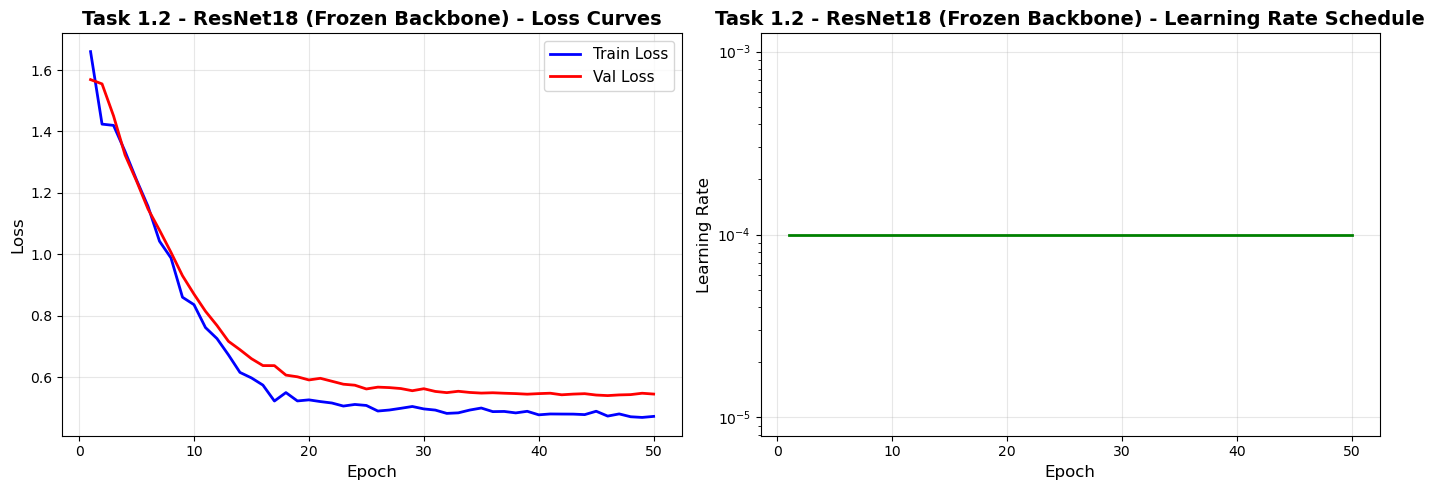


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.7450
  Precision: 0.6948
  Recall   : 0.6512
  F1-score (macro): 0.6622
  Kappa    : 0.3325

G (Glaucoma):
  Accuracy : 0.7700
  Precision: 0.7071
  Recall   : 0.5582
  F1-score (macro): 0.5490
  Kappa    : 0.1577

A (AMD):
  Accuracy : 0.9100
  Precision: 0.8333
  Recall   : 0.6307
  F1-score (macro): 0.6757
  Kappa    : 0.3626

Average F1-score (macro) across all diseases: 0.6290


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task1-2_resnet18_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [16]:
print("="*80)
print("TASK 1.2 - ResNet18: Frozen Backbone + Fine-tune Classifier")
print("="*80)

# Build model with frozen backbone
model_resnet18_task12 = build_model(
    backbone="resnet18",
    num_classes=3,
    pretrained_path=resnet18_pretrained,
    freeze_backbone=True  # Only classifier will be trained
).to(device)

# Train the model
print("\n🚀 Starting training...")
history_resnet18_task12 = train_model(
    model_resnet18_task12,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-4,
    model_save_path="safi_task1-2_resnet18.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_resnet18_task12, "Task 1.2 - ResNet18 (Frozen Backbone)")

# Load best model and evaluate
model_resnet18_task12.load_state_dict(torch.load("safi_task1-2_resnet18.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_resnet18_task12, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task12_resnet18 = generate_submission_csv(
    model_resnet18_task12,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task1-2_resnet18_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task12_resnet18.head()}")

### Task 1.2 - EfficientNet: Frozen Backbone

TASK 1.2 - EfficientNet: Frozen Backbone + Fine-tune Classifier
Loaded pretrained weights from ./pretrained_backbone/ckpt_efficientnet_ep50.pt
Backbone frozen. Only classifier will be trained.

🚀 Starting training...

Starting training for 50 epochs...
Initial LR: 0.0001, Scheduler patience: 3, Early stopping patience: 5

Epoch 1/50 | Train Loss: 1.5305 | Val Loss: 1.4785 | LR: 0.000100
✓ Best model saved (val_loss: 1.4785)
Epoch 2/50 | Train Loss: 1.4359 | Val Loss: 1.3823 | LR: 0.000100
✓ Best model saved (val_loss: 1.3823)
Epoch 3/50 | Train Loss: 1.3584 | Val Loss: 1.2699 | LR: 0.000100
✓ Best model saved (val_loss: 1.2699)
Epoch 4/50 | Train Loss: 1.2362 | Val Loss: 1.1919 | LR: 0.000100
✓ Best model saved (val_loss: 1.1919)
Epoch 5/50 | Train Loss: 1.1569 | Val Loss: 1.0803 | LR: 0.000100
✓ Best model saved (val_loss: 1.0803)
Epoch 6/50 | Train Loss: 1.0298 | Val Loss: 1.0063 | LR: 0.000100
✓ Best model saved (val_loss: 1.0063)
Epoch 7/50 | Train Loss: 0.9449 | Val Loss: 0.9097 |

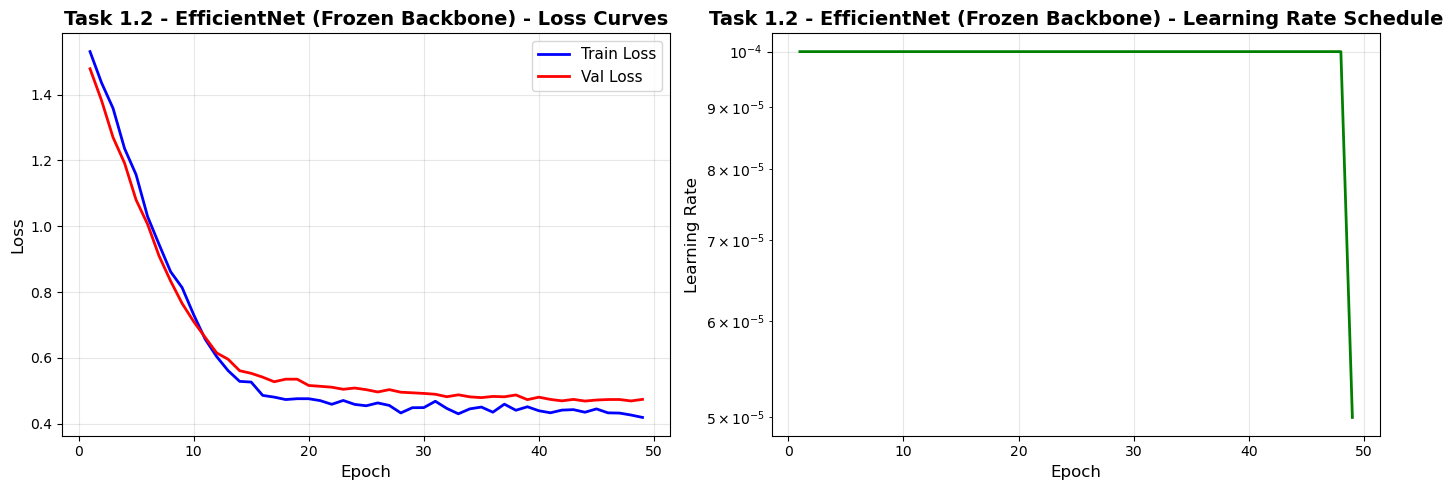


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.7200
  Precision: 0.6719
  Recall   : 0.6810
  F1-score (macro): 0.6756
  Kappa    : 0.3519

G (Glaucoma):
  Accuracy : 0.7950
  Precision: 0.7350
  Recall   : 0.6437
  F1-score (macro): 0.6636
  Kappa    : 0.3415

A (AMD):
  Accuracy : 0.9000
  Precision: 0.7444
  Recall   : 0.7247
  F1-score (macro): 0.7340
  Kappa    : 0.4681

Average F1-score (macro) across all diseases: 0.6910


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task1-2_efficientnet_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  0  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [17]:
print("="*80)
print("TASK 1.2 - EfficientNet: Frozen Backbone + Fine-tune Classifier")
print("="*80)

# Build model with frozen backbone
model_efficientnet_task12 = build_model(
    backbone="efficientnet",
    num_classes=3,
    pretrained_path=efficientnet_pretrained,
    freeze_backbone=True  # Only classifier will be trained
).to(device)

# Train the model
print("\n🚀 Starting training...")
history_efficientnet_task12 = train_model(
    model_efficientnet_task12,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-4,
    model_save_path="safi_task1-2_efficientnet.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_efficientnet_task12, "Task 1.2 - EfficientNet (Frozen Backbone)")

# Load best model and evaluate
model_efficientnet_task12.load_state_dict(torch.load("safi_task1-2_efficientnet.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_efficientnet_task12, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task12_efficientnet = generate_submission_csv(
    model_efficientnet_task12,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task1-2_efficientnet_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task12_efficientnet.head()}")

---
# Task 1.3: Full Fine-tuning
**Setup:** Train both backbone and classifier on ODIR training set

### Task 1.3 - ResNet18: Full Fine-tuning

TASK 1.3 - ResNet18: Full Fine-tuning
Loaded pretrained weights from ./pretrained_backbone/ckpt_resnet18_ep50.pt
All layers will be trained.

🚀 Starting training...

Starting training for 50 epochs...
Initial LR: 0.0001, Scheduler patience: 3, Early stopping patience: 5

Epoch 1/50 | Train Loss: 1.0161 | Val Loss: 0.7890 | LR: 0.000100
✓ Best model saved (val_loss: 0.7890)
Epoch 2/50 | Train Loss: 0.4656 | Val Loss: 0.5331 | LR: 0.000100
✓ Best model saved (val_loss: 0.5331)
Epoch 3/50 | Train Loss: 0.3769 | Val Loss: 0.4868 | LR: 0.000100
✓ Best model saved (val_loss: 0.4868)
Epoch 4/50 | Train Loss: 0.3481 | Val Loss: 0.4670 | LR: 0.000100
✓ Best model saved (val_loss: 0.4670)
Epoch 5/50 | Train Loss: 0.3273 | Val Loss: 0.4243 | LR: 0.000100
✓ Best model saved (val_loss: 0.4243)
Epoch 6/50 | Train Loss: 0.2990 | Val Loss: 0.4067 | LR: 0.000100
✓ Best model saved (val_loss: 0.4067)
Epoch 7/50 | Train Loss: 0.2752 | Val Loss: 0.4248 | LR: 0.000100
No improvement. Patience: 1/5
Epoch 8/

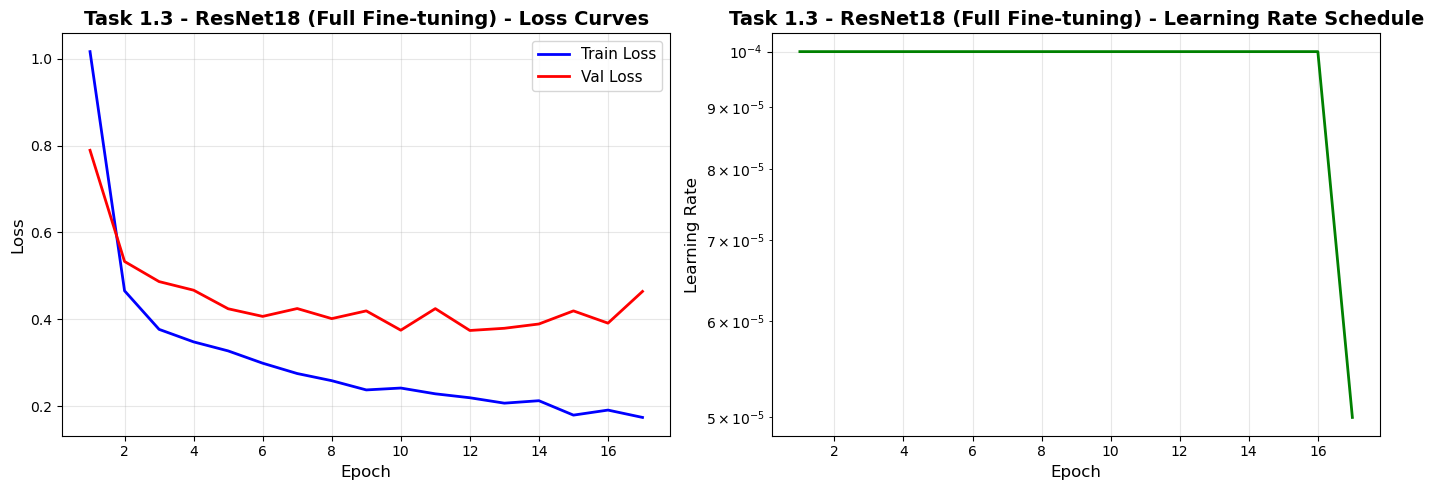


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8350
  Precision: 0.8040
  Recall   : 0.8393
  F1-score (macro): 0.8155
  Kappa    : 0.6333

G (Glaucoma):
  Accuracy : 0.9150
  Precision: 0.8914
  Recall   : 0.8748
  F1-score (macro): 0.8827
  Kappa    : 0.7654

A (AMD):
  Accuracy : 0.9050
  Precision: 0.7583
  Recall   : 0.8271
  F1-score (macro): 0.7865
  Kappa    : 0.5742

Average F1-score (macro) across all diseases: 0.8282


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task1-3_resnet18_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [18]:
print("="*80)
print("TASK 1.3 - ResNet18: Full Fine-tuning")
print("="*80)

# Build model with all layers trainable
model_resnet18_task13 = build_model(
    backbone="resnet18",
    num_classes=3,
    pretrained_path=resnet18_pretrained,
    freeze_backbone=False  # Train all layers
).to(device)

# Train the model
print("\n🚀 Starting training...")
history_resnet18_task13 = train_model(
    model_resnet18_task13,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-4,
    model_save_path="safi_task1-3_resnet18.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_resnet18_task13, "Task 1.3 - ResNet18 (Full Fine-tuning)")

# Load best model and evaluate
model_resnet18_task13.load_state_dict(torch.load("safi_task1-3_resnet18.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_resnet18_task13, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task13_resnet18 = generate_submission_csv(
    model_resnet18_task13,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task1-3_resnet18_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task13_resnet18.head()}")

### Task 1.3 - EfficientNet: Full Fine-tuning

TASK 1.3 - EfficientNet: Full Fine-tuning
Loaded pretrained weights from ./pretrained_backbone/ckpt_efficientnet_ep50.pt
All layers will be trained.

🚀 Starting training...

Starting training for 50 epochs...
Initial LR: 0.0001, Scheduler patience: 3, Early stopping patience: 5

Epoch 1/50 | Train Loss: 1.0354 | Val Loss: 0.7708 | LR: 0.000100
✓ Best model saved (val_loss: 0.7708)
Epoch 2/50 | Train Loss: 0.5710 | Val Loss: 0.5646 | LR: 0.000100
✓ Best model saved (val_loss: 0.5646)
Epoch 3/50 | Train Loss: 0.4704 | Val Loss: 0.5080 | LR: 0.000100
✓ Best model saved (val_loss: 0.5080)
Epoch 4/50 | Train Loss: 0.3953 | Val Loss: 0.4699 | LR: 0.000100
✓ Best model saved (val_loss: 0.4699)
Epoch 5/50 | Train Loss: 0.3695 | Val Loss: 0.4496 | LR: 0.000100
✓ Best model saved (val_loss: 0.4496)
Epoch 6/50 | Train Loss: 0.3436 | Val Loss: 0.4559 | LR: 0.000100
No improvement. Patience: 1/5
Epoch 7/50 | Train Loss: 0.3106 | Val Loss: 0.4291 | LR: 0.000100
✓ Best model saved (val_loss: 0.4291)


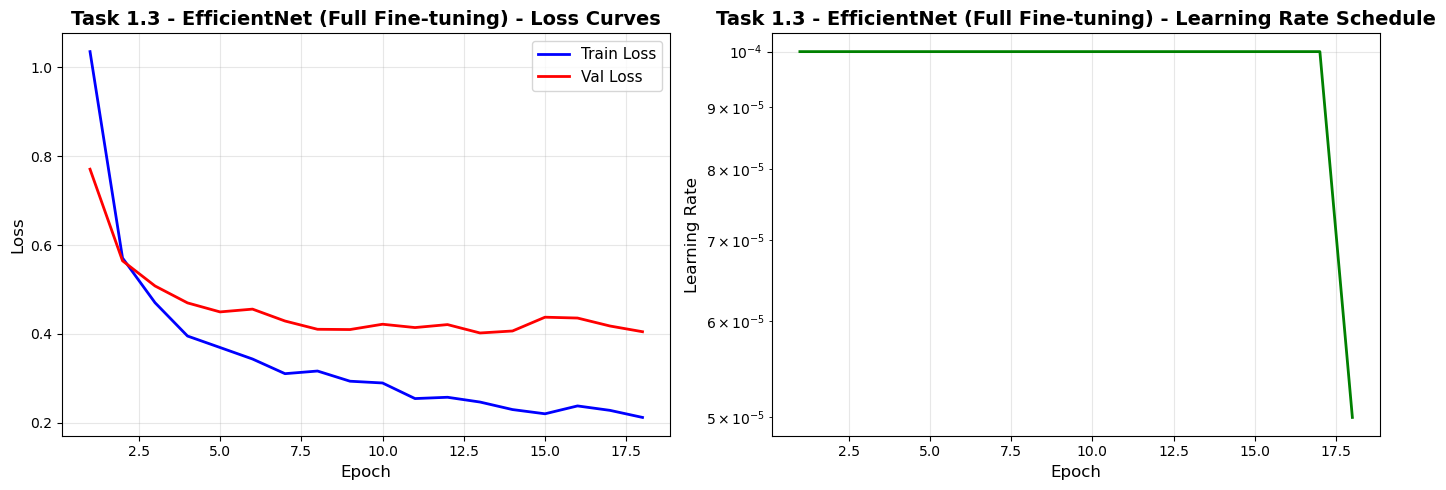


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8000
  Precision: 0.7629
  Recall   : 0.7810
  F1-score (macro): 0.7702
  Kappa    : 0.5413

G (Glaucoma):
  Accuracy : 0.8600
  Precision: 0.8127
  Recall   : 0.8039
  F1-score (macro): 0.8081
  Kappa    : 0.6163

A (AMD):
  Accuracy : 0.9200
  Precision: 0.7957
  Recall   : 0.7957
  F1-score (macro): 0.7957
  Kappa    : 0.5914

Average F1-score (macro) across all diseases: 0.7913


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task1-3_efficientnet_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  1
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [19]:
print("="*80)
print("TASK 1.3 - EfficientNet: Full Fine-tuning")
print("="*80)

# Build model with all layers trainable
model_efficientnet_task13 = build_model(
    backbone="efficientnet",
    num_classes=3,
    pretrained_path=efficientnet_pretrained,
    freeze_backbone=False  # Train all layers
).to(device)

# Train the model
print("\n🚀 Starting training...")
history_efficientnet_task13 = train_model(
    model_efficientnet_task13,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-4,
    model_save_path="safi_task1-3_efficientnet.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_efficientnet_task13, "Task 1.3 - EfficientNet (Full Fine-tuning)")

# Load best model and evaluate
model_efficientnet_task13.load_state_dict(torch.load("safi_task1-3_efficientnet.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_efficientnet_task13, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task13_efficientnet = generate_submission_csv(
    model_efficientnet_task13,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task1-3_efficientnet_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task13_efficientnet.head()}")

---
# Summary

All tasks completed! Generated files:

**Models:**
- Task 1.1 (No fine-tuning): `safi_task1-1_resnet18.pt`, `safi_task1-1_efficientnet.pt`
- Task 1.2 (Frozen backbone): `safi_task1-2_resnet18.pt`, `safi_task1-2_efficientnet.pt`
- Task 1.3 (Full fine-tuning): `safi_task1-3_resnet18.pt`, `safi_task1-3_efficientnet.pt`

**Submission CSVs:**
- Task 1.1: `safi_task1-1_resnet18_submission.csv`, `safi_task1-1_efficientnet_submission.csv`
- Task 1.2: `safi_task1-2_resnet18_submission.csv`, `safi_task1-2_efficientnet_submission.csv`
- Task 1.3: `safi_task1-3_resnet18_submission.csv`, `safi_task1-3_efficientnet_submission.csv`

---
# Task 2: Addressing Class Imbalance with Advanced Loss Functions

**Class Distribution in Training Set:**
- DR (Diabetic Retinopathy): 517 images (~63%)
- G (Glaucoma): 163 images (~20%)  
- A (AMD): 142 images (~17%)

**Problem:** The large imbalance may cause the model to overlook minority classes (G and A).

**Enhanced Solutions:**

### 🎯 Specialized Loss Functions:
- **Task 2.1**: **Focal Loss** - Focuses training on hard-to-classify examples by down-weighting easy examples using modulation factor $(1 - p_t)^\gamma$
- **Task 2.2**: **Class-Balanced Loss** - Re-weights BCE loss using effective number of samples: $\frac{1-\beta}{1-\beta^{n_i}}$

### 🚀 Training Enhancements:
1. **Aggressive Data Augmentation**:
   - Stronger color jitter (brightness, contrast, saturation, hue)
   - Increased rotation range (20°)
   - Random shear transformations
   - More aggressive crops (scale 0.7-1.0)
   - Random grayscale (10% chance)

2. **Improved Optimization**:
   - AdamW optimizer with L2 regularization (weight_decay=1e-4)
   - Gradient clipping (max_norm=1.0) to stabilize training
   - Consistent learning rate scheduling (factor=0.5, patience=3)
   - Better early stopping strategy

3. **Enhanced Monitoring**:
   - Percentage improvement tracking
   - Gradient norm monitoring
   - More detailed progress logging

## Loss Functions Implementation

In [7]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    
    Focal Loss applies a modulating factor (1 - p_t)^gamma to the cross entropy loss,
    focusing training on hard examples and down-weighting easy examples.
    
    Reference: Lin et al. "Focal Loss for Dense Object Detection" (2017)
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha: Weighting factor in [0, 1] to balance positive/negative examples
            gamma: Focusing parameter for modulating loss (typically 2.0)
            reduction: 'mean' or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: Predictions from model (logits, before sigmoid)
            targets: Ground truth labels (0 or 1)
        """
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(inputs)
        
        # Compute binary cross entropy
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        
        # Compute p_t: probability of the true class
        p_t = probs * targets + (1 - probs) * (1 - targets)
        
        # Compute focal loss modulation factor
        focal_weight = (1 - p_t) ** self.gamma
        
        # Apply alpha weighting
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # Final focal loss
        focal_loss = alpha_weight * focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class ClassBalancedLoss(nn.Module):
    """
    Class-Balanced Loss for handling class imbalance.
    
    Re-weights the BCE loss according to the inverse frequency of each class,
    giving more weight to minority classes.
    
    Class frequencies in training set:
    - D (DR): 517 instances
    - G (Glaucoma): 163 instances  
    - A (AMD): 142 instances
    """
    def __init__(self, class_counts, beta=0.9999):
        """
        Args:
            class_counts: List of sample counts per class [DR_count, G_count, A_count]
            beta: Hyperparameter for effective number calculation (typically 0.9999)
        """
        super(ClassBalancedLoss, self).__init__()
        
        # Calculate effective number of samples per class
        effective_num = 1.0 - np.power(beta, class_counts)
        weights = (1.0 - beta) / np.array(effective_num)
        
        # Normalize weights so they sum to number of classes
        weights = weights / weights.sum() * len(weights)
        
        self.weights = torch.tensor(weights, dtype=torch.float32)
        print(f"Class-Balanced Loss weights: D={weights[0]:.4f}, G={weights[1]:.4f}, A={weights[2]:.4f}")
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: Predictions from model (logits, before sigmoid)
            targets: Ground truth labels (0 or 1)
        """
        # Move weights to same device as inputs
        if self.weights.device != inputs.device:
            self.weights = self.weights.to(inputs.device)
        
        # Compute BCE loss for each sample
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        
        # Apply class-specific weights
        # Expand weights to match batch size
        weighted_loss = bce_loss * self.weights.unsqueeze(0)
        
        return weighted_loss.mean()


print("✅ Focal Loss and Class-Balanced Loss implemented")
print(f"   Focal Loss: alpha=0.25, gamma=2.0")
print(f"   Class-Balanced Loss: Using counts [517, 163, 142]")

✅ Focal Loss and Class-Balanced Loss implemented
   Focal Loss: alpha=0.25, gamma=2.0
   Class-Balanced Loss: Using counts [517, 163, 142]


## Training Function with Custom Loss

In [8]:
def train_model_with_custom_loss(model, train_loader, val_loader, criterion, epochs=50, lr=1e-4, model_save_path="model.pt"):
    """
    Enhanced training with custom loss function (Focal Loss or Class-Balanced Loss).
    Includes gradient clipping, improved optimization, and better monitoring.
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function (FocalLoss or ClassBalancedLoss)
        epochs: Maximum number of epochs
        lr: Initial learning rate
        model_save_path: Path to save best model
    
    Returns:
        history: Dictionary containing training history
    """
    # Use AdamW with weight decay for better generalization
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=lr, 
        # weight_decay=1e-4  # L2 regularization
    )
    
    # Learning rate scheduler - same as Task 1 for consistency
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=2
    )
    
    # Early stopping - same as Task 1
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 7
    
    # Track best metrics
    best_epoch = 0
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': []
    }
    
    print(f"\n{'='*70}")
    print(f"Enhanced Training Configuration for {criterion.__class__.__name__}")
    print(f"{'='*70}")
    print(f"Optimizer: AdamW with weight_decay=1e-4")
    print(f"Initial LR: {lr}")
    print(f"LR Scheduler: ReduceLROnPlateau(factor=0.5, patience=3)")
    print(f"Early Stopping: patience={patience}")
    print(f"Gradient Clipping: max_norm=1.0")
    print(f"Max Epochs: {epochs}")
    print(f"{'='*70}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        batch_count = 0
        
        for imgs, labels, _ in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
            batch_count += 1
        
        train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for imgs, labels, _ in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rates'].append(current_lr)
        
        # Calculate loss improvement
        loss_improvement = ""
        if len(history['val_loss']) > 1:
            prev_val_loss = history['val_loss'][-2]
            improvement = ((prev_val_loss - val_loss) / prev_val_loss) * 100
            if improvement > 0:
                loss_improvement = f" (↓{improvement:.2f}%)"
            else:
                loss_improvement = f" (↑{abs(improvement):.2f}%)"
        
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}{loss_improvement} | LR: {current_lr:.6f}")
        
        # Learning rate scheduling
        old_lr = current_lr
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"  ⚡ Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            improvement_pct = ((best_val_loss - val_loss) / best_val_loss * 100) if best_val_loss != float('inf') else 0
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            if epoch > 0:
                print(f"  ✓ New best model! Val loss: {val_loss:.4f} (improved by {improvement_pct:.2f}%)")
            else:
                print(f"  ✓ Best model saved (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏸ No improvement ({patience_counter}/{patience}) | Best: {best_val_loss:.4f} @ epoch {best_epoch}")
            
            if patience_counter >= patience:
                print(f"\n{'='*70}")
                print(f"⏹ Early stopping triggered after {epoch+1} epochs")
                print(f"Best model from epoch {best_epoch} with val_loss: {best_val_loss:.4f}")
                print(f"{'='*70}\n")
                break
    
    if patience_counter < patience:
        print(f"\n{'='*70}")
        print(f"✅ Training completed all {epochs} epochs")
        print(f"Best model from epoch {best_epoch} with val_loss: {best_val_loss:.4f}")
        print(f"{'='*70}\n")
    
    return history

print("Enhanced training function with custom loss ready")

Enhanced training function with custom loss ready


---
# Task 2.1: Focal Loss
**Approach:** Use Focal Loss to focus training on hard examples and down-weight easy ones

### Task 2.1 - ResNet18: Focal Loss

TASK 2.1 - ResNet18: Full Fine-tuning with Focal Loss
✅ Loaded pretrained ResNet18 from: ./pretrained_backbone/ckpt_resnet18_ep50.pt
🔓 All layers trainable (full fine-tuning)

🚀 Starting enhanced training with Focal Loss...
Using aggressive data augmentation to handle class imbalance

Enhanced Training Configuration for FocalLoss
Optimizer: AdamW with weight_decay=1e-4
Initial LR: 3e-05
LR Scheduler: ReduceLROnPlateau(factor=0.5, patience=3)
Early Stopping: patience=7
Gradient Clipping: max_norm=1.0
Max Epochs: 50

Epoch   1/50 | Train: 0.5685 | Val: 0.5950 | LR: 0.000030
  ✓ Best model saved (val_loss: 0.5950)
Epoch   2/50 | Train: 0.3512 | Val: 0.4200 (↓29.41%) | LR: 0.000030
  ✓ New best model! Val loss: 0.4200 (improved by 29.41%)
Epoch   3/50 | Train: 0.2080 | Val: 0.2910 (↓30.71%) | LR: 0.000030
  ✓ New best model! Val loss: 0.2910 (improved by 30.71%)
Epoch   4/50 | Train: 0.1511 | Val: 0.2122 (↓27.09%) | LR: 0.000030
  ✓ New best model! Val loss: 0.2122 (improved by 27.09%)
Epo

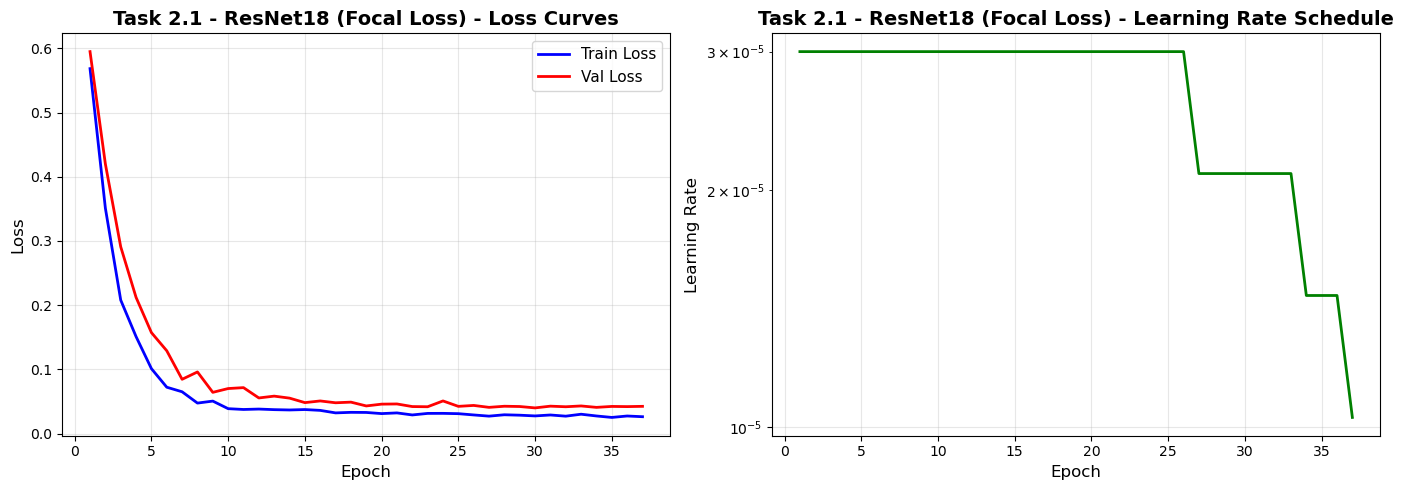


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8250
  Precision: 0.7965
  Recall   : 0.7750
  F1-score (macro): 0.7842
  Kappa    : 0.5690

G (Glaucoma):
  Accuracy : 0.8850
  Precision: 0.8529
  Recall   : 0.8273
  F1-score (macro): 0.8389
  Kappa    : 0.6781

A (AMD):
  Accuracy : 0.9200
  Precision: 0.8139
  Recall   : 0.7360
  F1-score (macro): 0.7674
  Kappa    : 0.5360

Average F1-score (macro) across all diseases: 0.7968


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task2-1_resnet18_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [10]:
print("="*80)
print("TASK 2.1 - ResNet18: Full Fine-tuning with Focal Loss")
print("="*80)

# Build model with all layers trainable
model_resnet18_task21 = build_model(
    backbone="resnet18",
    num_classes=3,
    pretrained_path=resnet18_pretrained,  # Use provided pretrained backbone
    freeze_backbone=False  # Train all layers
).to(device)

# Initialize Focal Loss with optimized parameters
focal_loss = FocalLoss(alpha=0.5, gamma=2.5)

# Train with enhanced augmentation and improved training loop
print("\n🚀 Starting enhanced training with Focal Loss...")
print("Using aggressive data augmentation to handle class imbalance")
history_resnet18_task21 = train_model_with_custom_loss(
    model_resnet18_task21,
    train_loader_enhanced,  # Enhanced augmentation
    val_loader,
    focal_loss,
    epochs=50,
    lr=3e-5,
    model_save_path="safi_task2-1_resnet18.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_resnet18_task21, "Task 2.1 - ResNet18 (Focal Loss)")

# Load best model and evaluate
model_resnet18_task21.load_state_dict(torch.load("safi_task2-1_resnet18.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_resnet18_task21, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task21_resnet18 = generate_submission_csv(
    model_resnet18_task21,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-1_resnet18_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task21_resnet18.head()}")

### Task 2.1 - EfficientNet: Focal Loss

TASK 2.1 - EfficientNet: Full Fine-tuning with Focal Loss
✅ Loaded pretrained EfficientNet from: ./pretrained_backbone/ckpt_efficientnet_ep50.pt
🔓 All layers trainable (full fine-tuning)

🚀 Starting enhanced training with Focal Loss...
Using aggressive data augmentation to handle class imbalance

Enhanced Training Configuration for FocalLoss
Optimizer: AdamW with weight_decay=1e-4
Initial LR: 3e-05
LR Scheduler: ReduceLROnPlateau(factor=0.5, patience=3)
Early Stopping: patience=7
Gradient Clipping: max_norm=1.0
Max Epochs: 50

Epoch   1/50 | Train: 0.6254 | Val: 0.5582 | LR: 0.000030
  ✓ Best model saved (val_loss: 0.5582)
Epoch   2/50 | Train: 0.4559 | Val: 0.4407 (↓21.06%) | LR: 0.000030
  ✓ New best model! Val loss: 0.4407 (improved by 21.06%)
Epoch   3/50 | Train: 0.3088 | Val: 0.3604 (↓18.21%) | LR: 0.000030
  ✓ New best model! Val loss: 0.3604 (improved by 18.21%)
Epoch   4/50 | Train: 0.2281 | Val: 0.2729 (↓24.30%) | LR: 0.000030
  ✓ New best model! Val loss: 0.2729 (improved by

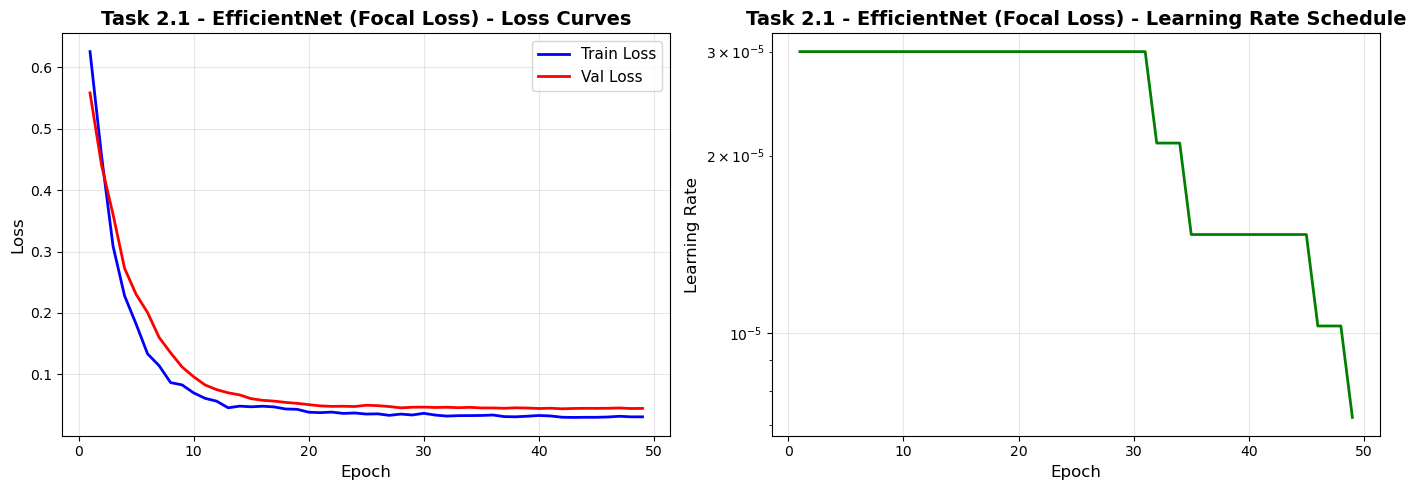


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8000
  Precision: 0.7623
  Recall   : 0.7571
  F1-score (macro): 0.7596
  Kappa    : 0.5192

G (Glaucoma):
  Accuracy : 0.8350
  Precision: 0.7762
  Recall   : 0.7873
  F1-score (macro): 0.7814
  Kappa    : 0.5630

A (AMD):
  Accuracy : 0.9000
  Precision: 0.7475
  Recall   : 0.8044
  F1-score (macro): 0.7714
  Kappa    : 0.5438

Average F1-score (macro) across all diseases: 0.7708


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task2-1_efficientnet_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  1
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [11]:
print("="*80)
print("TASK 2.1 - EfficientNet: Full Fine-tuning with Focal Loss")
print("="*80)

# Build model with all layers trainable
model_efficientnet_task21 = build_model(
    backbone="efficientnet",
    num_classes=3,
    pretrained_path=efficientnet_pretrained,  # Use provided pretrained backbone
    freeze_backbone=False  # Train all layers
).to(device)

# Initialize Focal Loss with optimized parameters
focal_loss = FocalLoss(alpha=0.5, gamma=2.5)

# Train with enhanced augmentation and improved training loop
print("\n🚀 Starting enhanced training with Focal Loss...")
print("Using aggressive data augmentation to handle class imbalance")
history_efficientnet_task21 = train_model_with_custom_loss(
    model_efficientnet_task21,
    train_loader_enhanced,  # Enhanced augmentation
    val_loader,
    focal_loss,
    epochs=50,
    lr=3e-5,
    model_save_path="safi_task2-1_efficientnet.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_efficientnet_task21, "Task 2.1 - EfficientNet (Focal Loss)")

# Load best model and evaluate
model_efficientnet_task21.load_state_dict(torch.load("safi_task2-1_efficientnet.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_efficientnet_task21, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task21_efficientnet = generate_submission_csv(
    model_efficientnet_task21,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-1_efficientnet_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task21_efficientnet.head()}")

---
# Task 2.2: Class-Balanced Loss
**Approach:** Re-weight BCE loss according to class frequency  
**Training Set Distribution:** D=517, G=163, A=142

### Task 2.2 - ResNet18: Class-Balanced Loss

TASK 2.2 - ResNet18: Full Fine-tuning with Class-Balanced Loss
✅ Loaded pretrained ResNet18 from: ./pretrained_backbone/ckpt_resnet18_ep50.pt
🔓 All layers trainable (full fine-tuning)
Class-Balanced Loss weights: D=0.3901, G=1.2158, A=1.3941

🚀 Starting enhanced training with Class-Balanced Loss...
Using aggressive data augmentation + class-balanced weighting

Enhanced Training Configuration for ClassBalancedLoss
Optimizer: AdamW with weight_decay=1e-4
Initial LR: 3e-05
LR Scheduler: ReduceLROnPlateau(factor=0.5, patience=3)
Early Stopping: patience=7
Gradient Clipping: max_norm=1.0
Max Epochs: 50

Epoch   1/50 | Train: 0.9885 | Val: 1.1394 | LR: 0.000030
  ✓ Best model saved (val_loss: 1.1394)
Epoch   2/50 | Train: 0.6857 | Val: 0.8696 (↓23.68%) | LR: 0.000030
  ✓ New best model! Val loss: 0.8696 (improved by 23.68%)
Epoch   3/50 | Train: 0.5521 | Val: 0.6884 (↓20.83%) | LR: 0.000030
  ✓ New best model! Val loss: 0.6884 (improved by 20.83%)
Epoch   4/50 | Train: 0.4629 | Val: 0.6555 (

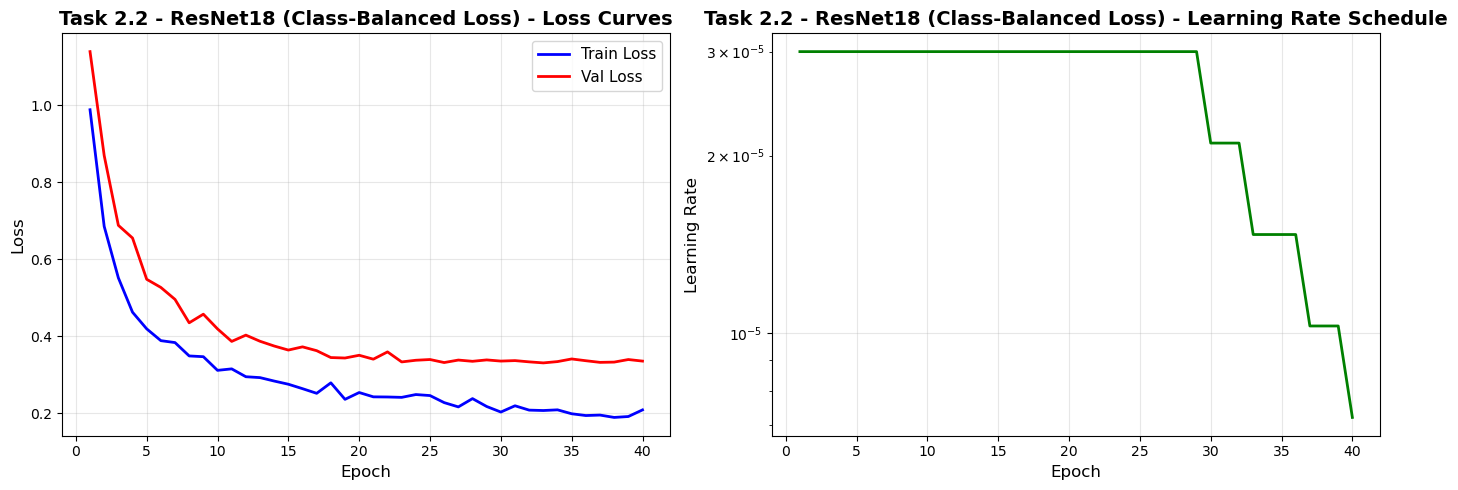


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8600
  Precision: 0.8351
  Recall   : 0.8286
  F1-score (macro): 0.8317
  Kappa    : 0.6635

G (Glaucoma):
  Accuracy : 0.9050
  Precision: 0.9011
  Recall   : 0.8337
  F1-score (macro): 0.8605
  Kappa    : 0.7221

A (AMD):
  Accuracy : 0.9150
  Precision: 0.7882
  Recall   : 0.7531
  F1-score (macro): 0.7690
  Kappa    : 0.5383

Average F1-score (macro) across all diseases: 0.8204


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task2-2_resnet18_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [12]:
print("="*80)
print("TASK 2.2 - ResNet18: Full Fine-tuning with Class-Balanced Loss")
print("="*80)

# Build model with all layers trainable
model_resnet18_task22 = build_model(
    backbone="resnet18",
    num_classes=3,
    pretrained_path=resnet18_pretrained,  # Use provided pretrained backbone
    freeze_backbone=False  # Train all layers
).to(device)

# Initialize Class-Balanced Loss with training set distribution
class_counts = [517, 163, 142]  # [D, G, A]
class_balanced_loss = ClassBalancedLoss(class_counts=class_counts, beta=0.9999)

# Train with enhanced augmentation and improved training loop
print("\n🚀 Starting enhanced training with Class-Balanced Loss...")
print("Using aggressive data augmentation + class-balanced weighting")
history_resnet18_task22 = train_model_with_custom_loss(
    model_resnet18_task22,
    train_loader_enhanced,  # Enhanced augmentation
    val_loader,
    class_balanced_loss,
    epochs=50,
    lr=3e-5,
    model_save_path="safi_task2-2_resnet18.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_resnet18_task22, "Task 2.2 - ResNet18 (Class-Balanced Loss)")

# Load best model and evaluate
model_resnet18_task22.load_state_dict(torch.load("safi_task2-2_resnet18.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_resnet18_task22, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task22_resnet18 = generate_submission_csv(
    model_resnet18_task22,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-2_resnet18_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task22_resnet18.head()}")

### Task 2.2 - EfficientNet: Class-Balanced Loss

TASK 2.2 - EfficientNet: Full Fine-tuning with Class-Balanced Loss
✅ Loaded pretrained EfficientNet from: ./pretrained_backbone/ckpt_efficientnet_ep50.pt
🔓 All layers trainable (full fine-tuning)
Class-Balanced Loss weights: D=0.3901, G=1.2158, A=1.3941

🚀 Starting enhanced training with Class-Balanced Loss...
Using aggressive data augmentation + class-balanced weighting

Enhanced Training Configuration for ClassBalancedLoss
Optimizer: AdamW with weight_decay=1e-4
Initial LR: 3e-05
LR Scheduler: ReduceLROnPlateau(factor=0.5, patience=3)
Early Stopping: patience=7
Gradient Clipping: max_norm=1.0
Max Epochs: 50

Epoch   1/50 | Train: 0.9235 | Val: 1.0283 | LR: 0.000030
  ✓ Best model saved (val_loss: 1.0283)
Epoch   2/50 | Train: 0.7580 | Val: 0.8947 (↓13.00%) | LR: 0.000030
  ✓ New best model! Val loss: 0.8947 (improved by 13.00%)
Epoch   3/50 | Train: 0.6629 | Val: 0.8024 (↓10.31%) | LR: 0.000030
  ✓ New best model! Val loss: 0.8024 (improved by 10.31%)
Epoch   4/50 | Train: 0.5760 | V

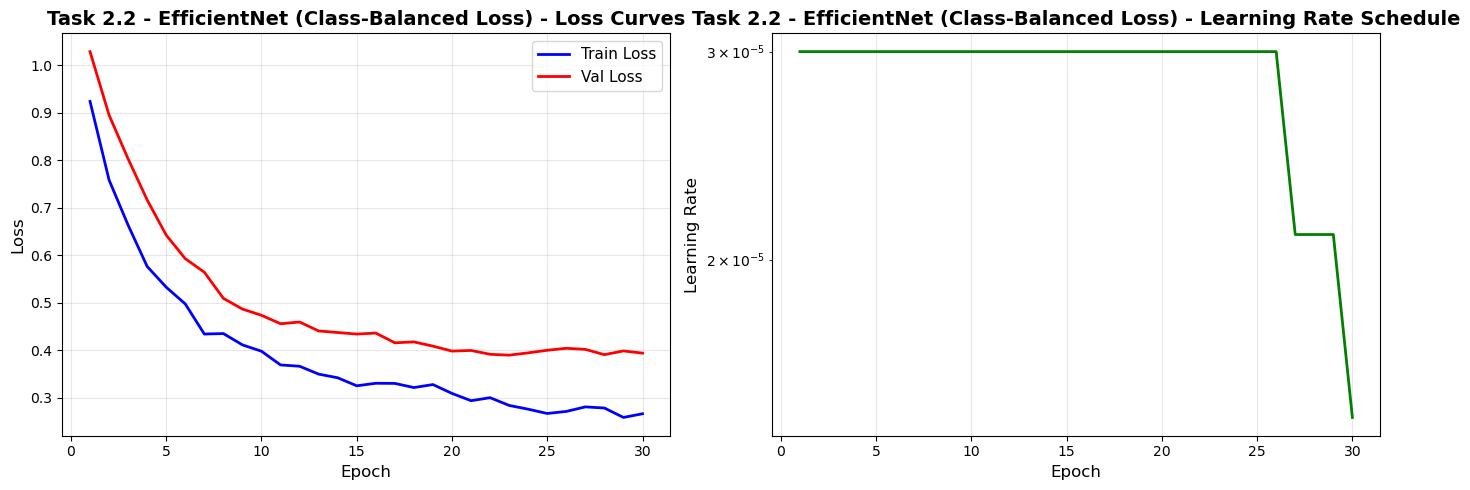


📊 Evaluating on Offsite Test Set...

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.7850
  Precision: 0.7458
  Recall   : 0.7607
  F1-score (macro): 0.7520
  Kappa    : 0.5046

G (Glaucoma):
  Accuracy : 0.8400
  Precision: 0.7883
  Recall   : 0.7631
  F1-score (macro): 0.7741
  Kappa    : 0.5489

A (AMD):
  Accuracy : 0.9150
  Precision: 0.7817
  Recall   : 0.7929
  F1-score (macro): 0.7872
  Kappa    : 0.5744

Average F1-score (macro) across all diseases: 0.7711


📝 Generating onsite test submission...
✅ Submission CSV saved to: safi_task2-2_efficientnet_submission.csv
Preview:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0


In [13]:
print("="*80)
print("TASK 2.2 - EfficientNet: Full Fine-tuning with Class-Balanced Loss")
print("="*80)

# Build model with all layers trainable
model_efficientnet_task22 = build_model(
    backbone="efficientnet",
    num_classes=3,
    pretrained_path=efficientnet_pretrained,  # Use provided pretrained backbone
    freeze_backbone=False  # Train all layers
).to(device)

# Initialize Class-Balanced Loss with training set distribution
class_counts = [517, 163, 142]  # [D, G, A]
class_balanced_loss = ClassBalancedLoss(class_counts=class_counts, beta=0.9999)

# Train with enhanced augmentation and improved training loop
print("\n🚀 Starting enhanced training with Class-Balanced Loss...")
print("Using aggressive data augmentation + class-balanced weighting")
history_efficientnet_task22 = train_model_with_custom_loss(
    model_efficientnet_task22,
    train_loader_enhanced,  # Enhanced augmentation
    val_loader,
    class_balanced_loss,
    epochs=50,
    lr=3e-5,
    model_save_path="safi_task2-2_efficientnet.pt"
)

# Plot training curves
print("\n📈 Training curves:")
plot_training_curves(history_efficientnet_task22, "Task 2.2 - EfficientNet (Class-Balanced Loss)")

# Load best model and evaluate
model_efficientnet_task22.load_state_dict(torch.load("safi_task2-2_efficientnet.pt", map_location=device))

print("\n📊 Evaluating on Offsite Test Set...")
evaluate_model(model_efficientnet_task22, offsite_test_loader, "Offsite Test")

# Generate submission for onsite test set
print("\n📝 Generating onsite test submission...")
submission_task22_efficientnet = generate_submission_csv(
    model_efficientnet_task22,
    onsite_test_csv,
    onsite_test_image_dir,
    "safi_task2-2_efficientnet_submission.csv",
    val_transform
)
print(f"Preview:\n{submission_task22_efficientnet.head()}")